In [10]:
import pandas as pd
from darts import TimeSeries
from darts.models import BlockRNNModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [11]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [12]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [13]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = BlockRNNModel(
        model="LSTM",
        model_name=f"model_{fold+1}",
        input_chunk_length=65,
        hidden_dim=122,
        n_rnn_layers=1,
        n_epochs=100,
        batch_size=106,
        dropout=0.12887879111838008,
        add_encoders=encoders,
        output_chunk_length=1,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.SmoothL1Loss(),
        optimizer_cls=torch.optim.Adam,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":4, "min_lr":1e-6},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        random_state=42,
        optimizer_kwargs={"lr": 0.0016408452237179332, "weight_decay": 9.711713443577775e-05},
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12887879111838008 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.049
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.044
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.039
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.030
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.027
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.025
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.023
Metric val_loss improved b

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE        R2  \
Temperature                    9.212911    3.035278    2.366405  0.815603   
Precipitation_accumulated      0.298398    0.546258    0.283132  0.538723   
Humidity                      53.970421    7.346456    5.588902  0.830777   
Wind_Speed_kmh                 0.349994    0.591603    0.475592  0.190805   
Soil_Moisture              97141.371980  311.675106  245.802267  0.847841   
Soil_Temperature              14.141854    3.760566    2.952132  0.804911   
Wind_Dir_Sin                   0.262303    0.512156    0.409077  0.182508   
Wind_Dir_Cos                   0.315278    0.561496    0.432197  0.164387   

                                SMAPE  
Temperature                 15.224199  
Precipitation_accumulated    8.055238  
Humidity                     8.766377  
Wind_Speed_kmh              53.363034  
Soil_Moisture   

Metric val_loss improved. New best score: 6.470
Metric val_loss improved by 0.030 >= min_delta = 0.001. New best score: 6.439
Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 6.421
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 6.417
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 6.412
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 6.408
Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 6.395
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 6.389
Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 6.374
Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 6.357
Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 6.348
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 6.342
Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 6.331
Metric val_loss 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE         R2  \
Temperature                1.892538e+02    13.756956    11.851721  -4.724893   
Precipitation_accumulated  1.401067e+05   374.308259   325.917825  -2.789093   
Humidity                   9.692597e+02    31.132936    27.521491  -6.683998   
Wind_Speed_kmh             4.142310e+00     2.035267     1.626686 -13.063955   
Soil_Moisture              1.622724e+07  4028.305397  3508.425562 -10.673720   
Soil_Temperature           2.080487e+02    14.423895    12.410802  -5.012025   
Wind_Dir_Sin               5.403791e-01     0.735105     0.678600  -1.407965   
Wind_Dir_Cos               6.269031e-01     0.791772     0.690653   0.021482   

                                SMAPE  
Temperature                 51.101226  
Precipitation_accumulated  143.888384  
Humidity                    28.171568  
Wind_Speed_kmh             15

Metric val_loss improved. New best score: 0.005
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12887879111838008 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which m

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE            R2  \
Temperature                   2.542366   1.594480   1.280199  5.048162e-01   
Precipitation_accumulated    76.213185   8.730016   6.953253 -7.435695e+05   
Humidity                     30.097096   5.486082   4.485669 -7.696898e-01   
Wind_Speed_kmh                0.011179   0.105732   0.086414          -inf   
Soil_Moisture              6611.401366  81.310524  65.350213 -3.838372e+00   
Soil_Temperature              4.715548   2.171531   1.657994  1.891103e-01   
Wind_Dir_Sin                  0.002189   0.046791   0.038679          -inf   
Wind_Dir_Cos                  0.008095   0.089971   0.075709          -inf   

                                SMAPE  
Temperature                  9.327407  
Precipitation_accumulated    1.506956  
Humidity                     5.204887  
Wind_Speed_kmh             200.000000  
Soil_Mo

Metric val_loss improved. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12887879111838008 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    1.309432    1.144304    0.912325 -1.537928e+00   
Precipitation_accumulated   1498.242803   38.707142   36.994222 -4.489667e+04   
Humidity                      18.393835    4.288803    3.374729 -8.366644e-01   
Wind_Speed_kmh                 0.051462    0.226852    0.203355          -inf   
Soil_Moisture              75139.725642  274.116263  242.449455 -1.507264e+00   
Soil_Temperature               1.148210    1.071546    0.869349 -4.962578e+00   
Wind_Dir_Sin                   0.000774    0.027814    0.022345          -inf   
Wind_Dir_Cos                   0.003276    0.057234    0.052877          -inf   

                                SMAPE  
Temperature                 10.142764  
Precipitation_accumulated    8.444828  
Humidity                     3.757796  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.004
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12887879111838008 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which m

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE        MAE          R2  \
Temperature                    1.942604    1.393773   1.101930    0.169343   
Precipitation_accumulated    151.027687   12.289332   9.848934 -515.822942   
Humidity                      42.943216    6.553107   5.483280    0.037207   
Wind_Speed_kmh                 0.071145    0.266731   0.219605  -31.992650   
Soil_Moisture              10632.977318  103.116329  85.595299   -0.275590   
Soil_Temperature               2.530378    1.590716   1.266813   -0.591276   
Wind_Dir_Sin                   0.015113    0.122933   0.058484    0.747154   
Wind_Dir_Cos                   0.022887    0.151286   0.095015    0.749707   

                                SMAPE  
Temperature                 16.050843  
Precipitation_accumulated    2.179843  
Humidity                     6.537084  
Wind_Speed_kmh             193.040087  
Soil_Mo

Metric val_loss improved. New best score: 0.036
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.031
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.023
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.020
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.018
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.017
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.016
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.015
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.015. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12887879111838008 and num_lay

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                     3.347391    1.829588    1.409778    0.654117   
Precipitation_accumulated     447.080793   21.144285   16.964834 -392.858734   
Humidity                       87.991884    9.380399    8.024922    0.200956   
Wind_Speed_kmh                  0.758938    0.871171    0.643592    0.512810   
Soil_Moisture              668179.668351  817.422576  727.032702    0.415067   
Soil_Temperature                7.935619    2.817023    2.179176   -0.578259   
Wind_Dir_Sin                    0.363587    0.602981    0.459586    0.263186   
Wind_Dir_Cos                    0.292631    0.540954    0.424062    0.385063   

                                SMAPE  
Temperature                 38.466519  
Precipitation_accumulated    3.777551  
Humidity                     8.914326  
Wind_Speed_kmh              8

Metric val_loss improved. New best score: 0.020
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.017
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.013
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.012
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12887879111838008 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.1

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                    3.803501    1.950257    1.585016    0.858281   
Precipitation_accumulated    132.855418   11.526292    9.683785 -549.399540   
Humidity                      24.691430    4.969047    3.937492    0.832606   
Wind_Speed_kmh                 0.618233    0.786278    0.605854    0.488846   
Soil_Moisture              16532.462199  128.578623  111.161440   -1.800710   
Soil_Temperature               2.211174    1.487002    1.164924    0.799406   
Wind_Dir_Sin                   0.399394    0.631976    0.526830    0.261208   
Wind_Dir_Cos                   0.288431    0.537058    0.438112    0.127617   

                                SMAPE  
Temperature                 16.878241  
Precipitation_accumulated    2.106147  
Humidity                     4.836713  
Wind_Speed_kmh              56.556822 

In [14]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12887879111838008 and num_layers=1


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=122, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.12887879111838008, activation=ReLU, model_name=model_1, input_chunk_length=65, n_epochs=100, batch_size=106, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, output_chunk_length=1, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f9d407baed0>]}, loss_fn=SmoothL1Loss(), optimizer_cls=<class 'torch.optim.adam.Adam'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 4, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, random_state=42, optimizer_kwargs={'lr': 0.0016408452237179332, 'weight_decay': 9.711713443577775e

In [15]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


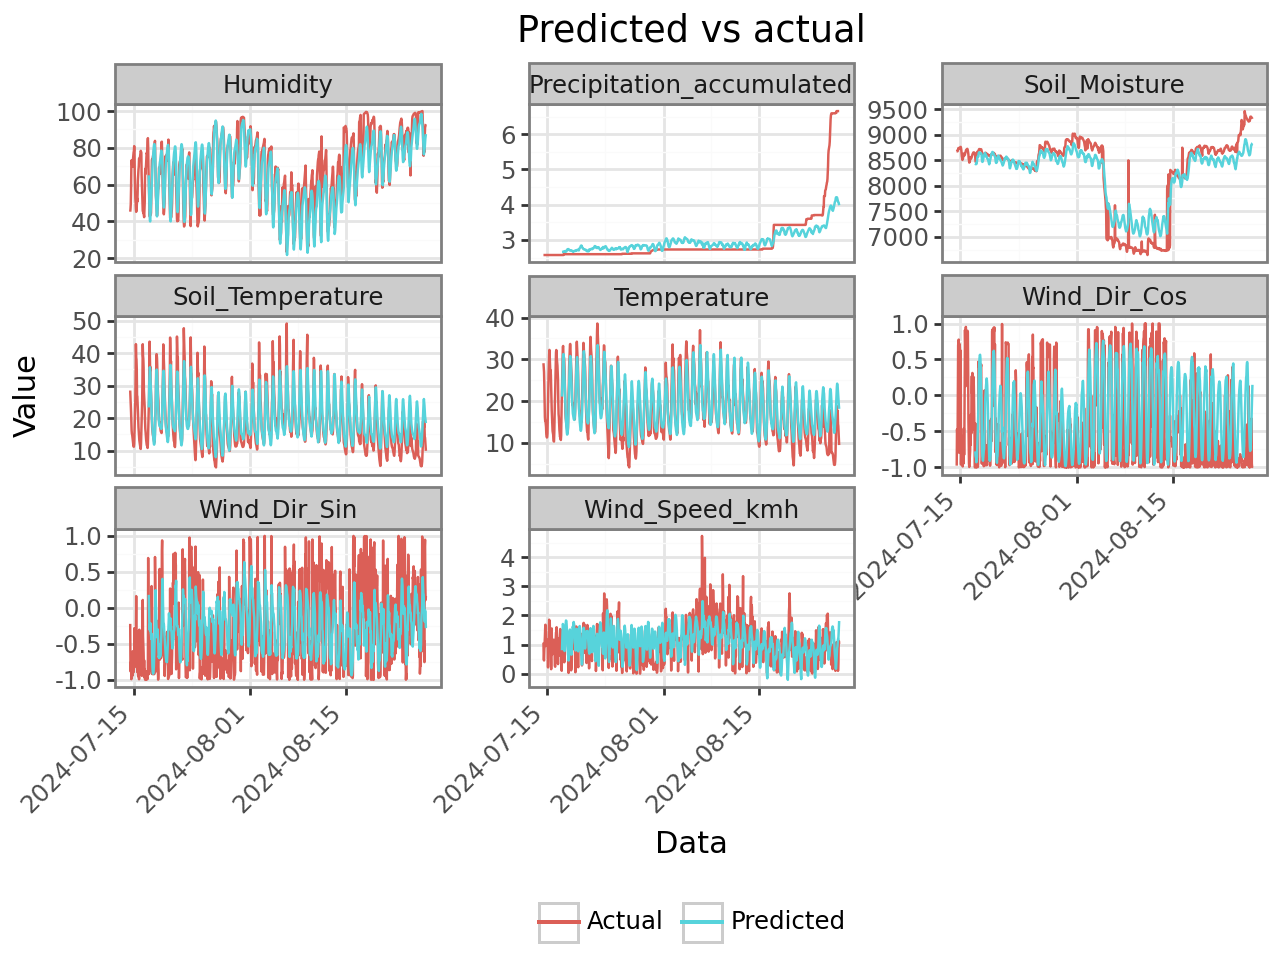

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual.png


In [16]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot.show()
plot.save('predict_actual.png', width=12, height=10, dpi=300)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

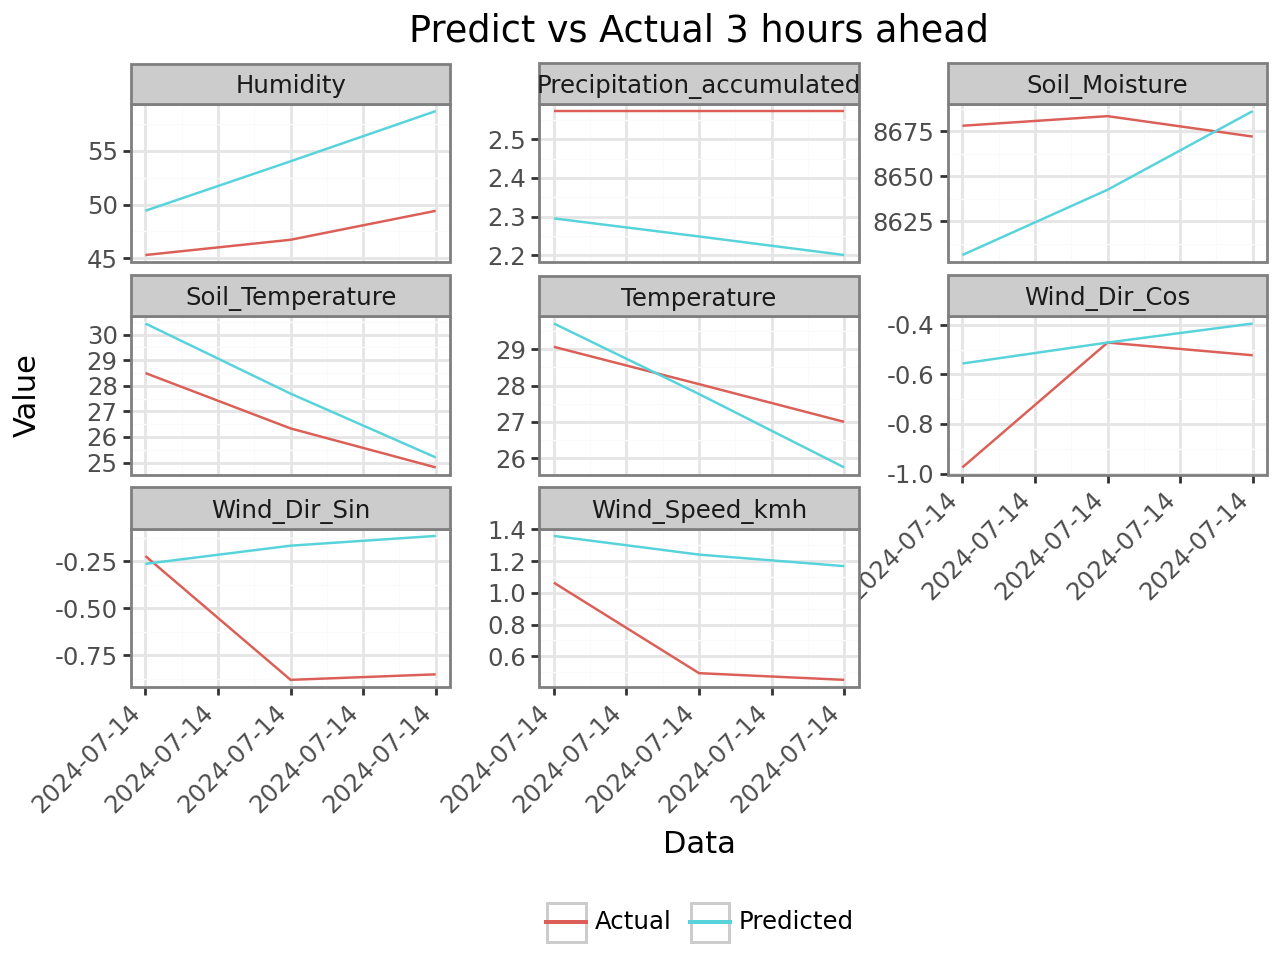

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/LSTM/predict_3.png
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(0.6858567873360752), 'RMSE': np.float64(0.8281647102696874), 'MAE': np.float64(0.7226973744581228), 'R2': np.float64(0.03380181604616184), 'SMAPE': np.float64(2.6379416303339744)}, 'Precipitation_accumulated': {'MSE': np.float64(0.10669015113162429), 'RMSE': np.float64(0.32663458348990587), 'MAE': np.float64(0.32434337559390825), 'R2': np.float64(-inf), 'SMAPE': np.float64(13.469570354489827)}, 'Humidity': {'MSE': np.float64(52.255757870961155), 'RMSE': np.float64(7.228814416691105), 'MAE': np.float64(6.908606393624827), 'R2': np.float64(-16.927713658532127), 'SMAPE': np.float64(13.467551731645687)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.38573178192470303), 'RMSE': np.float64(0.621073089035987), 'MAE': np.float64(0.5858228109374565), 'R2': np.float64(-3.957055498698436), 'SMAPE': np.float64(66.26574506150912)}, 'Soil_Moisture': {'MSE': np.float64(2336.1820766474934), 'RMSE': np.float64(48.3340674539966), 'MAE': np.float64(42.22550094081695), 'R2': np

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

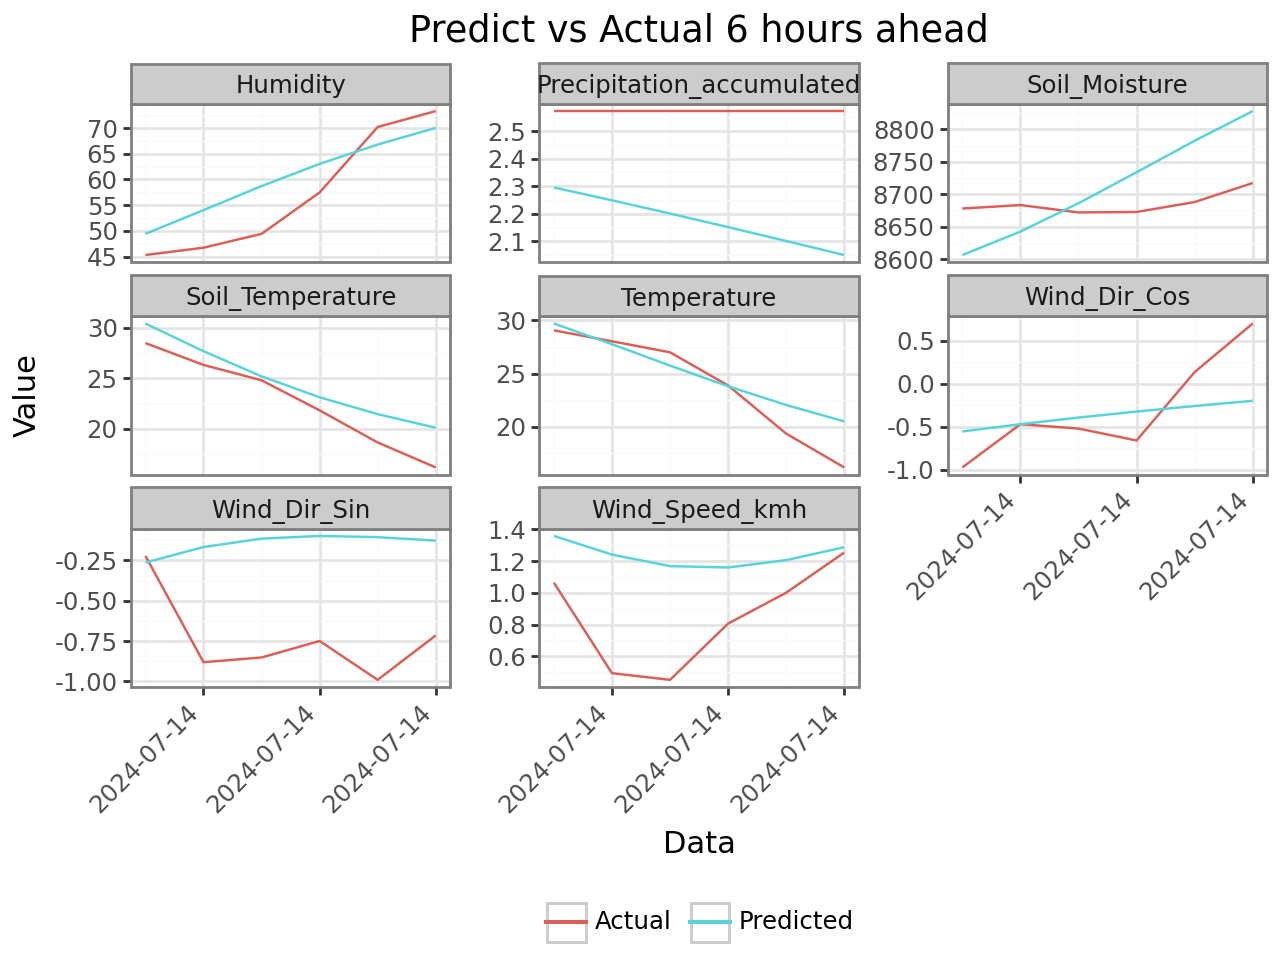

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/LSTM/predict_6.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(4.669925780145076), 'RMSE': np.float64(2.1610011060027423), 'MAE': np.float64(1.5427062358641688), 'R2': np.float64(0.7900809397146079), 'SMAPE': np.float64(7.462834543746291)}, 'Precipitation_accumulated': {'MSE': np.float64(0.1654976022094926), 'RMSE': np.float64(0.40681396511119505), 'MAE': np.float64(0.3980702754655614), 'R2': np.float64(-8.391725391087842e+29), 'SMAPE': np.float64(16.83880788482279)}, 'Humidity': {'MSE': np.float64(34.98191503400539), 'RMSE': np.float64(5.914551127009165), 'MAE': np.float64(5.4923495015806365), 'R2': np.float64(0.7163276904128535), 'SMAPE': np.float64(9.858997683678231)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.22088263876063785), 'RMSE': np.float64(0.4699815302335166), 'MAE': np.float64(0.3915838655866708), 'R2': np.float64(-1.5575918244463676), 'SMAPE': np.float64(42.663054990994105)}, 'Soil_Moisture': {'MSE': np.float64(5334.234233568909), 'RMSE': np.float64(73.03584211583316), 'MAE': np.float64(65.570882481574

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

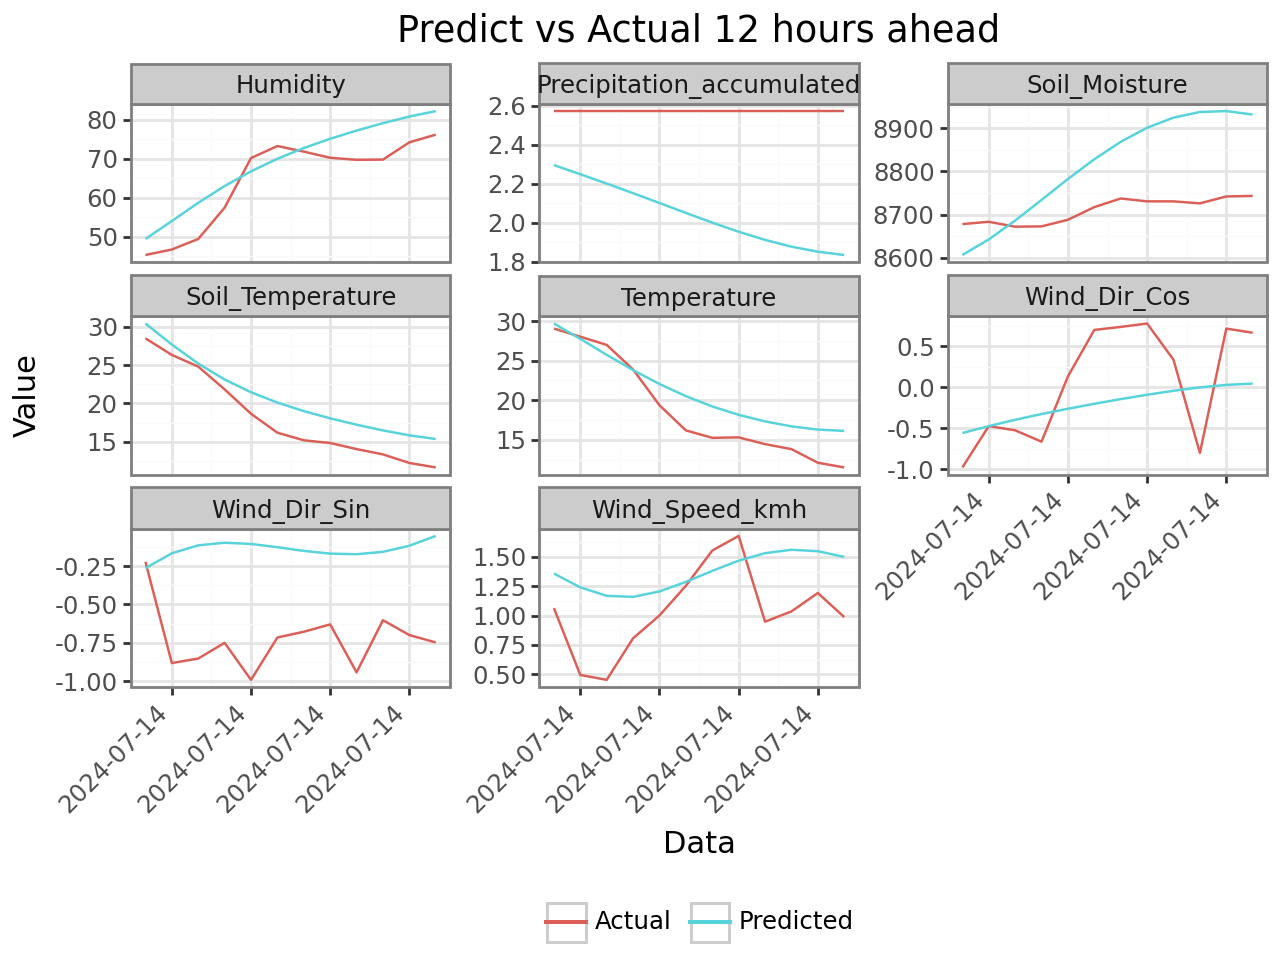

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/LSTM/predict_12.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(8.954508611210832), 'RMSE': np.float64(2.9924084967147837), 'MAE': np.float64(2.5543125233950863), 'R2': np.float64(0.7653630872186388), 'SMAPE': np.float64(15.405527130269354)}, 'Precipitation_accumulated': {'MSE': np.float64(0.3075175336425572), 'RMSE': np.float64(0.5545426346481911), 'MAE': np.float64(0.53301298594063), 'R2': np.float64(-1.5592991444107694e+30), 'SMAPE': np.float64(23.357580679429123)}, 'Humidity': {'MSE': np.float64(38.25824720415893), 'RMSE': np.float64(6.185325149429004), 'MAE': np.float64(5.692284426460611), 'R2': np.float64(0.6827059861034935), 'SMAPE': np.float64(8.842072960314377)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.20060104836638026), 'RMSE': np.float64(0.4478850838846727), 'MAE': np.float64(0.39272737601004076), 'R2': np.float64(-0.6557651503205701), 'SMAPE': np.float64(36.33447946830289)}, 'Soil_Moisture': {'MSE': np.float64(19634.069610744027), 'RMSE': np.float64(140.12162435093316), 'MAE': np.float64(123.9743684941

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

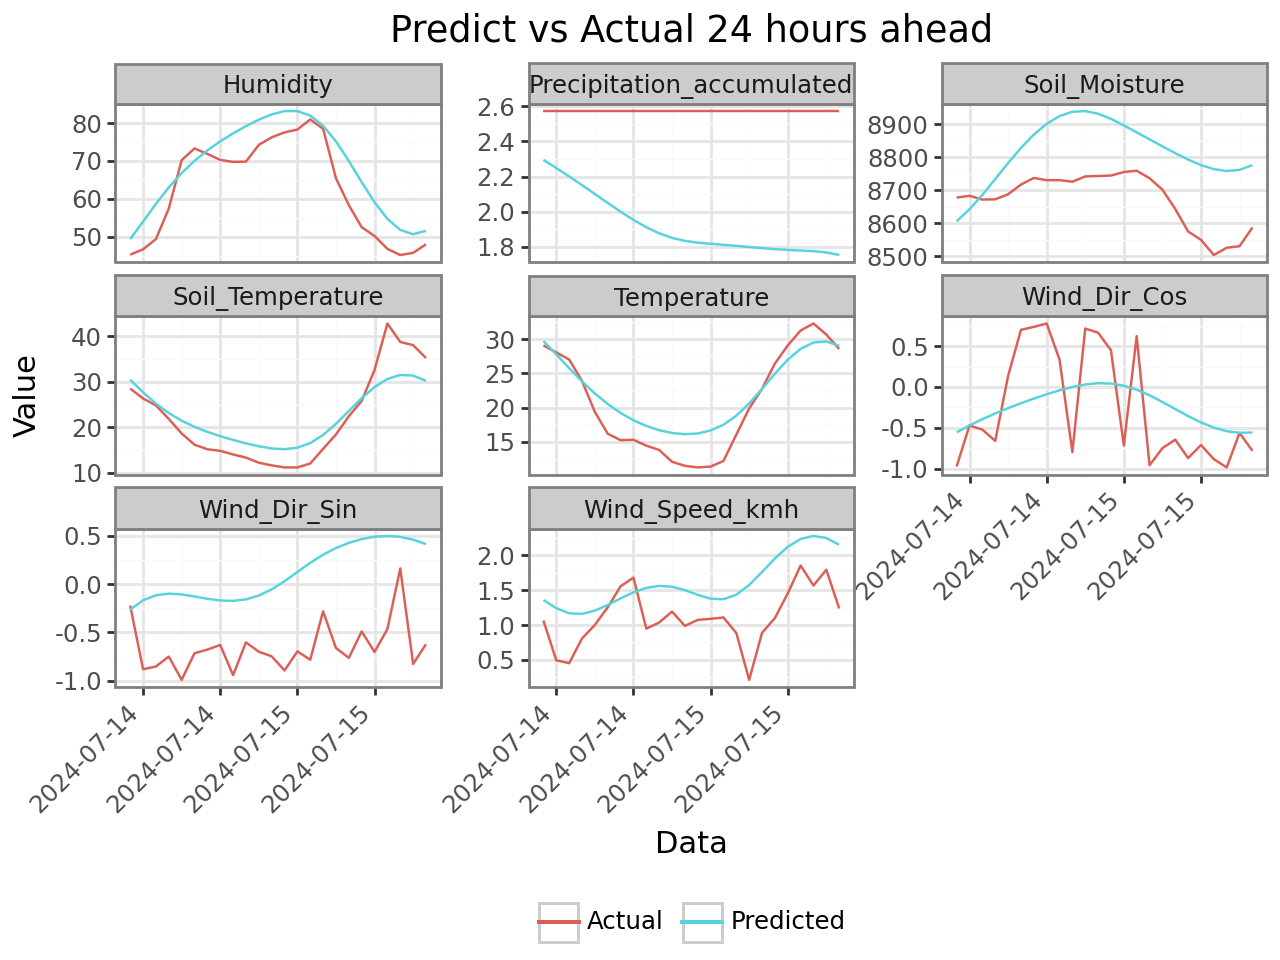

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/LSTM/predict_24.png
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(9.100623166919938), 'RMSE': np.float64(3.0167239129426373), 'MAE': np.float64(2.505667901788808), 'R2': np.float64(0.8296149427754143), 'SMAPE': np.float64(14.566533036997763)}, 'Precipitation_accumulated': {'MSE': np.float64(0.45899394231687535), 'RMSE': np.float64(0.6774909167781331), 'MAE': np.float64(0.6570395430577711), 'R2': np.float64(-inf), 'SMAPE': np.float64(29.578737839369023)}, 'Humidity': {'MSE': np.float64(46.18391851024089), 'RMSE': np.float64(6.795875109964933), 'MAE': np.float64(6.068880996033331), 'R2': np.float64(0.7138798533176414), 'SMAPE': np.float64(9.84622389885722)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.35266144106902636), 'RMSE': np.float64(0.5938530466950779), 'MAE': np.float64(0.5159921487987383), 'R2': np.float64(-1.240530681412455), 'SMAPE': np.float64(41.66550720070247)}, 'Soil_Moisture': {'MSE': np.float64(27820.63560974052), 'RMSE': np.float64(166.79519060734492), 'MAE': np.float64(153.81716054533408), 'R2': np.float

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

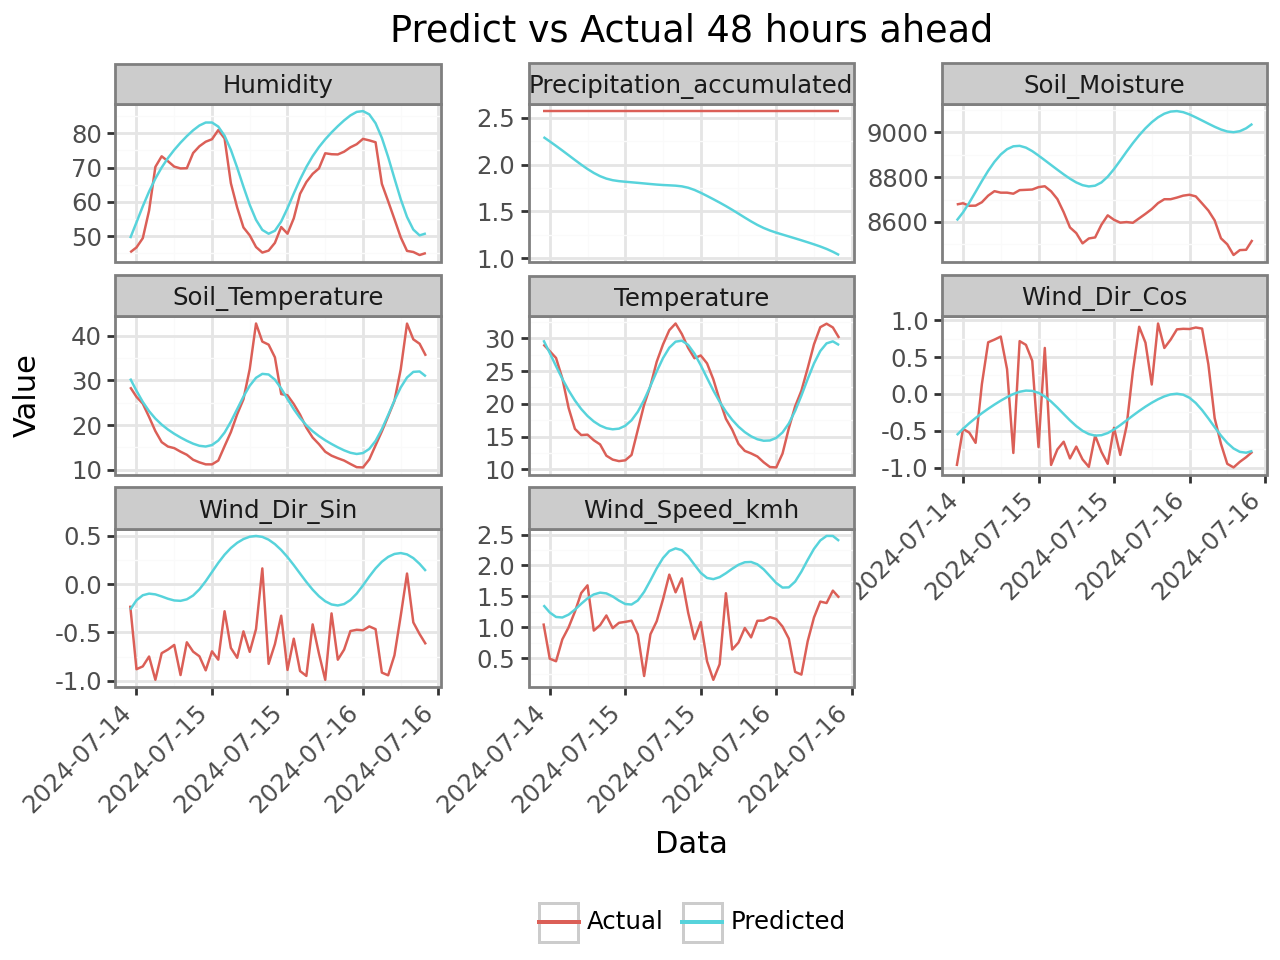

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/LSTM/predict_48.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(7.4974243926145485), 'RMSE': np.float64(2.7381425077257298), 'MAE': np.float64(2.3222774309546192), 'R2': np.float64(0.8636846720582043), 'SMAPE': np.float64(13.434257478642479)}, 'Precipitation_accumulated': {'MSE': np.float64(0.9940189239885203), 'RMSE': np.float64(0.9970049769126131), 'MAE': np.float64(0.9379492360052682), 'R2': np.float64(-5.040274742529066e+30), 'SMAPE': np.float64(46.19759807981359)}, 'Humidity': {'MSE': np.float64(55.71509165237067), 'RMSE': np.float64(7.464254259627727), 'MAE': np.float64(6.807654095411166), 'R2': np.float64(0.6348062478095371), 'SMAPE': np.float64(10.69552396204837)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.7918601377296867), 'RMSE': np.float64(0.8898652357125132), 'MAE': np.float64(0.7874871801533424), 'R2': np.float64(-3.6417627075438315), 'SMAPE': np.float64(60.13679282136766)}, 'Soil_Moisture': {'MSE': np.float64(95332.25770325765), 'RMSE': np.float64(308.759222863476), 'MAE': np.float64(273.3174870381541)

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

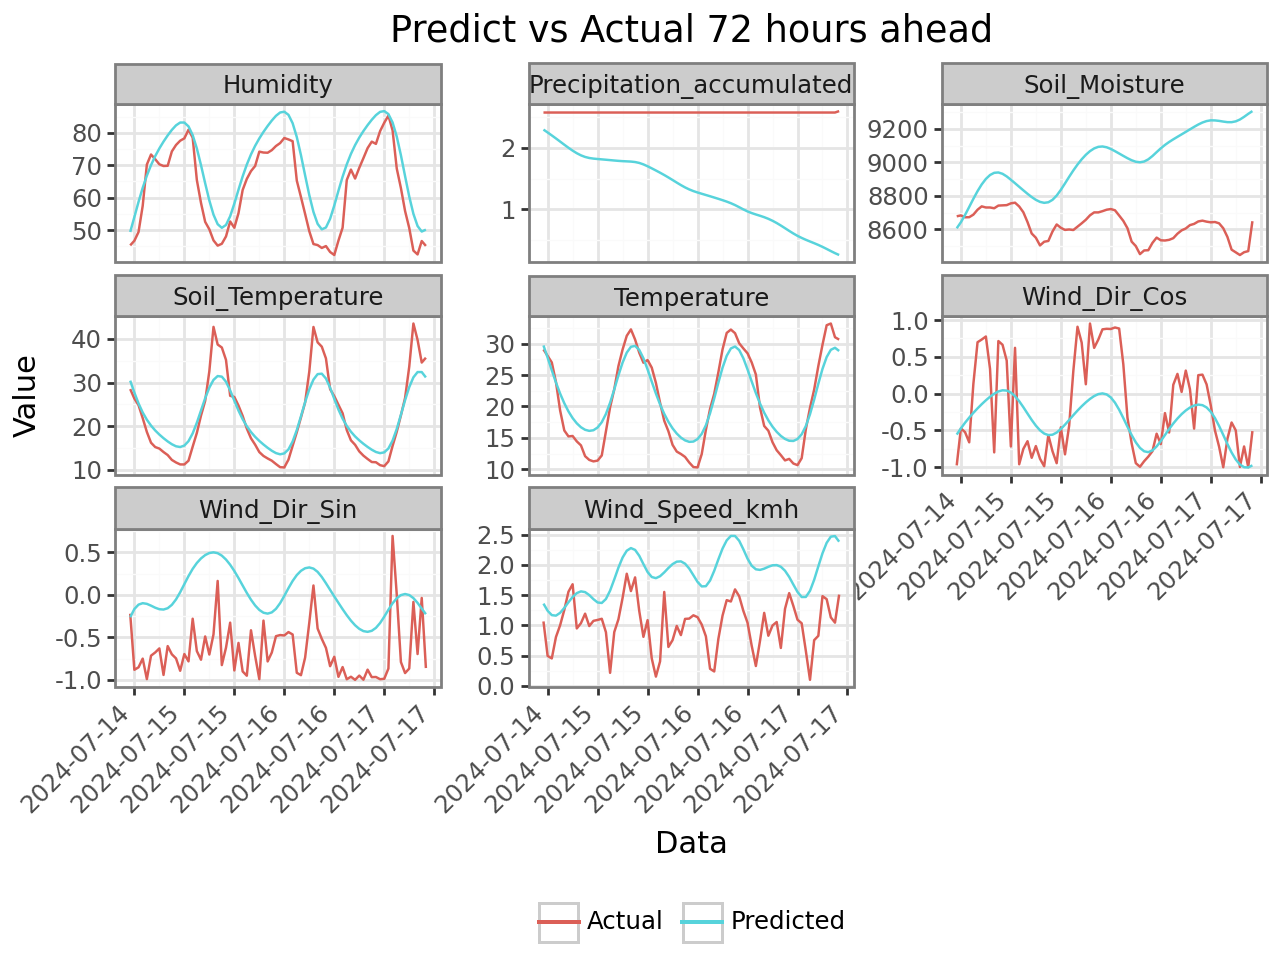

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/LSTM/predict_72.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(7.758754772115369), 'RMSE': np.float64(2.785454141089989), 'MAE': np.float64(2.427661554767627), 'R2': np.float64(0.8648185090067546), 'SMAPE': np.float64(13.695060195064245)}, 'Precipitation_accumulated': {'MSE': np.float64(1.9308192795004946), 'RMSE': np.float64(1.3895392328036278), 'MAE': np.float64(1.2708127088397747), 'R2': np.float64(-260049.6594038984), 'SMAPE': np.float64(71.56678340375068)}, 'Humidity': {'MSE': np.float64(64.9779755451986), 'RMSE': np.float64(8.060891733871545), 'MAE': np.float64(7.283830139322806), 'R2': np.float64(0.6225265746355502), 'SMAPE': np.float64(11.618927596185031)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.8834739778259291), 'RMSE': np.float64(0.9399329645383915), 'MAE': np.float64(0.8480864788587437), 'R2': np.float64(-4.6003462009694145), 'SMAPE': np.float64(63.40205202373542)}, 'Soil_Moisture': {'MSE': np.float64(200751.49517463625), 'RMSE': np.float64(448.0530048717855), 'MAE': np.float64(393.9606036420064), 'R2

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

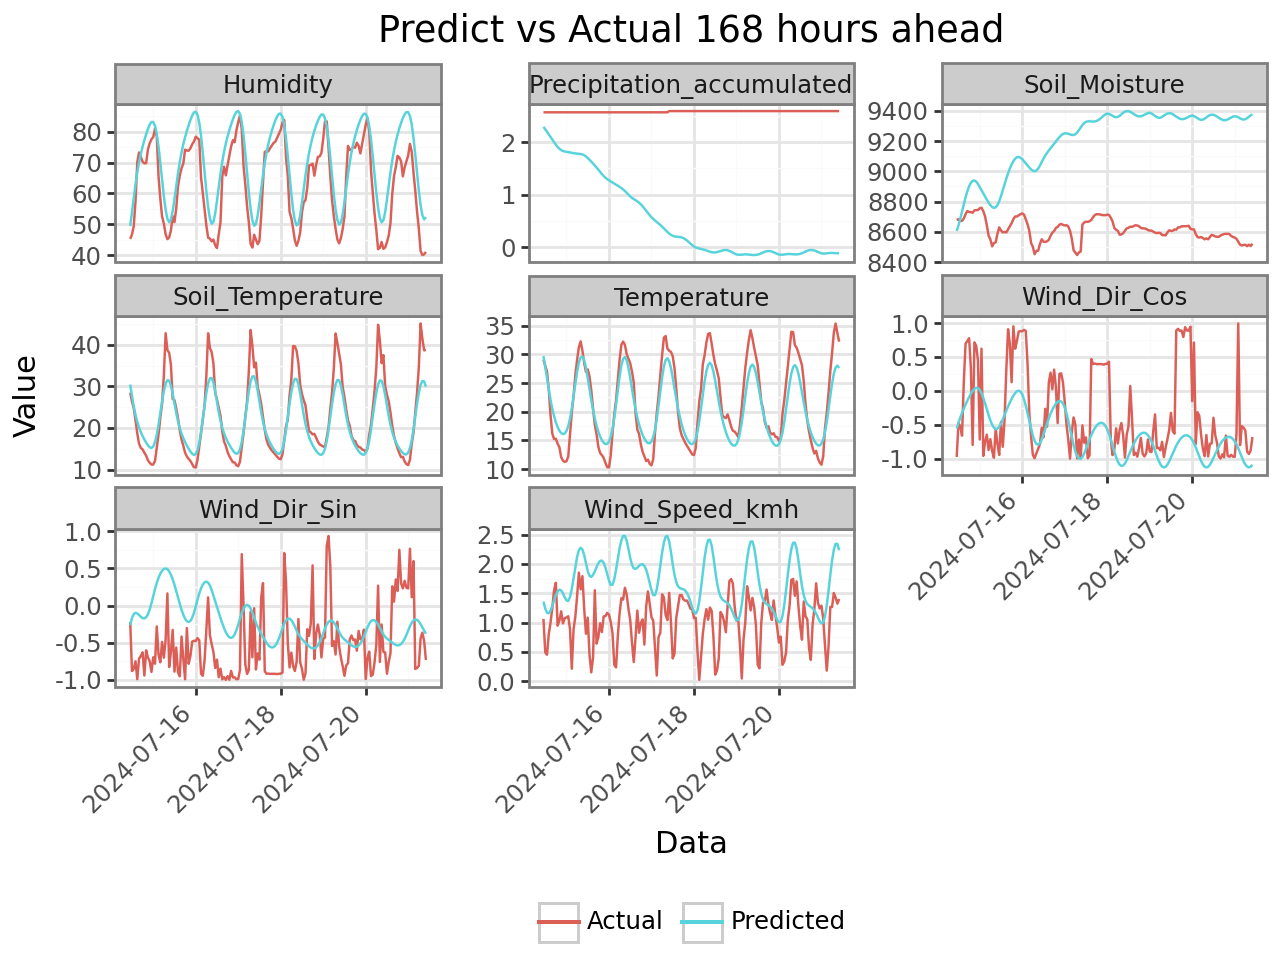

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/LSTM/predict_168.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(9.993710173813373), 'RMSE': np.float64(3.1612829948951697), 'MAE': np.float64(2.7054419832315237), 'R2': np.float64(0.817176590832124), 'SMAPE': np.float64(13.323256310366233)}, 'Precipitation_accumulated': {'MSE': np.float64(4.888674330984957), 'RMSE': np.float64(2.211034674306343), 'MAE': np.float64(2.066965787865394), 'R2': np.float64(-36955.36738662247), 'SMAPE': np.float64(143.17317109666504)}, 'Humidity': {'MSE': np.float64(74.36637240435974), 'RMSE': np.float64(8.623593937817326), 'MAE': np.float64(7.670801496995328), 'R2': np.float64(0.5826353931300831), 'SMAPE': np.float64(12.24042013349009)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.7244059322016936), 'RMSE': np.float64(0.8511203981821218), 'MAE': np.float64(0.7215933748484112), 'R2': np.float64(-3.172221370198476), 'SMAPE': np.float64(56.735210782610096)}, 'Soil_Moisture': {'MSE': np.float64(411836.1515724581), 'RMSE': np.float64(641.7446155383449), 'MAE': np.float64(599.0939469003058), 'R2':

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

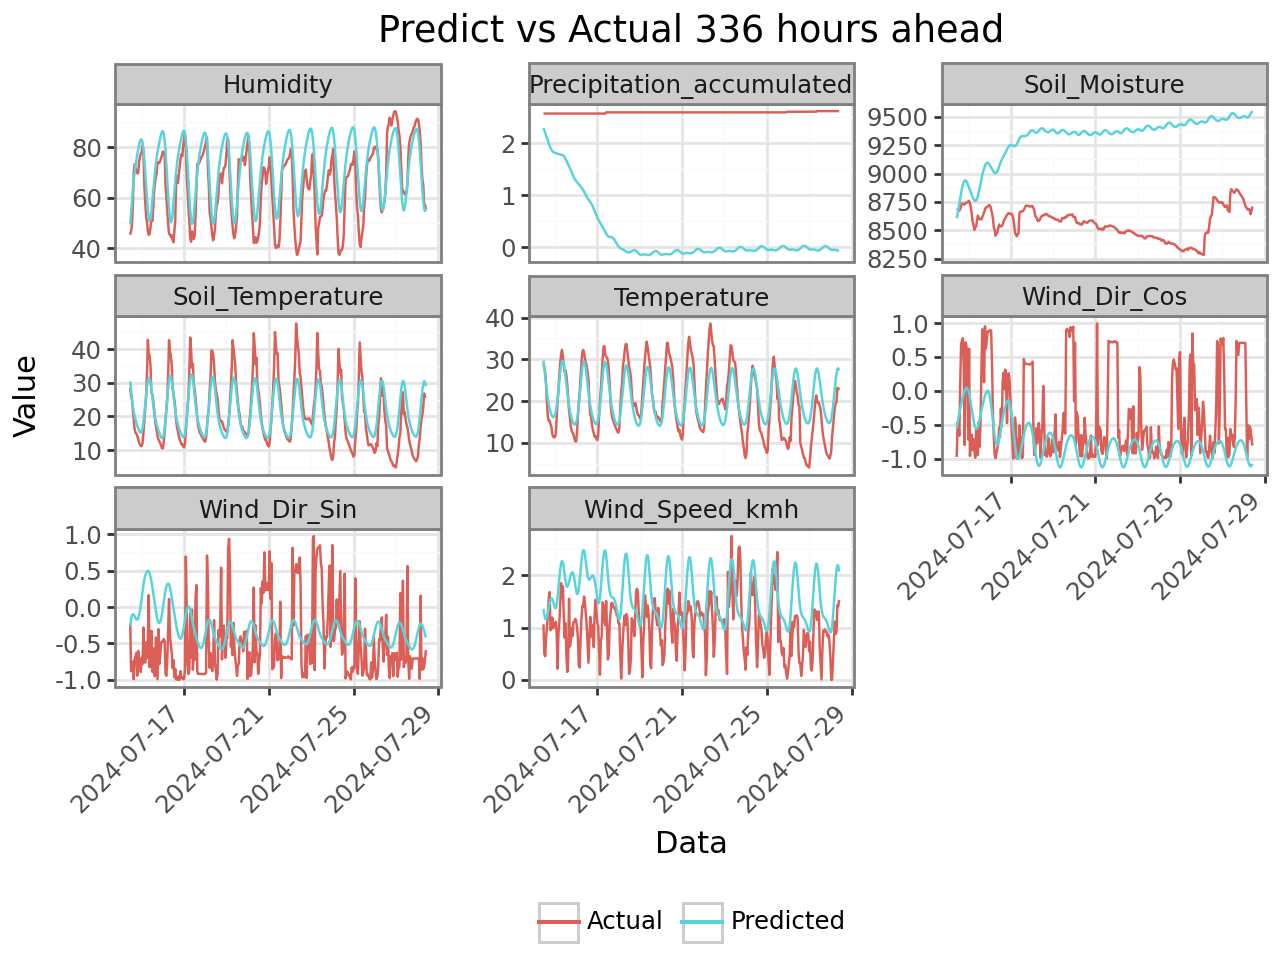

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/LSTM/predict_336.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(21.529358194311584), 'RMSE': np.float64(4.6399739432793785), 'MAE': np.float64(3.8691139368168654), 'R2': np.float64(0.6641638461921715), 'SMAPE': np.float64(22.434396000759175)}, 'Precipitation_accumulated': {'MSE': np.float64(5.947641620386386), 'RMSE': np.float64(2.438778714928106), 'MAE': np.float64(2.3568851274699045), 'R2': np.float64(-34469.02350914744), 'SMAPE': np.float64(171.4526220029385)}, 'Humidity': {'MSE': np.float64(101.20237155901582), 'RMSE': np.float64(10.059938944099802), 'MAE': np.float64(8.71148909199196), 'R2': np.float64(0.5183388871121999), 'SMAPE': np.float64(13.603506921849641)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.5931954495367745), 'RMSE': np.float64(0.7701918264541467), 'MAE': np.float64(0.6437264240938502), 'R2': np.float64(-1.3456577557071472), 'SMAPE': np.float64(55.60877112197572)}, 'Soil_Moisture': {'MSE': np.float64(636010.781027926), 'RMSE': np.float64(797.5028407648), 'MAE': np.float64(757.6962962588232), 'R2':

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

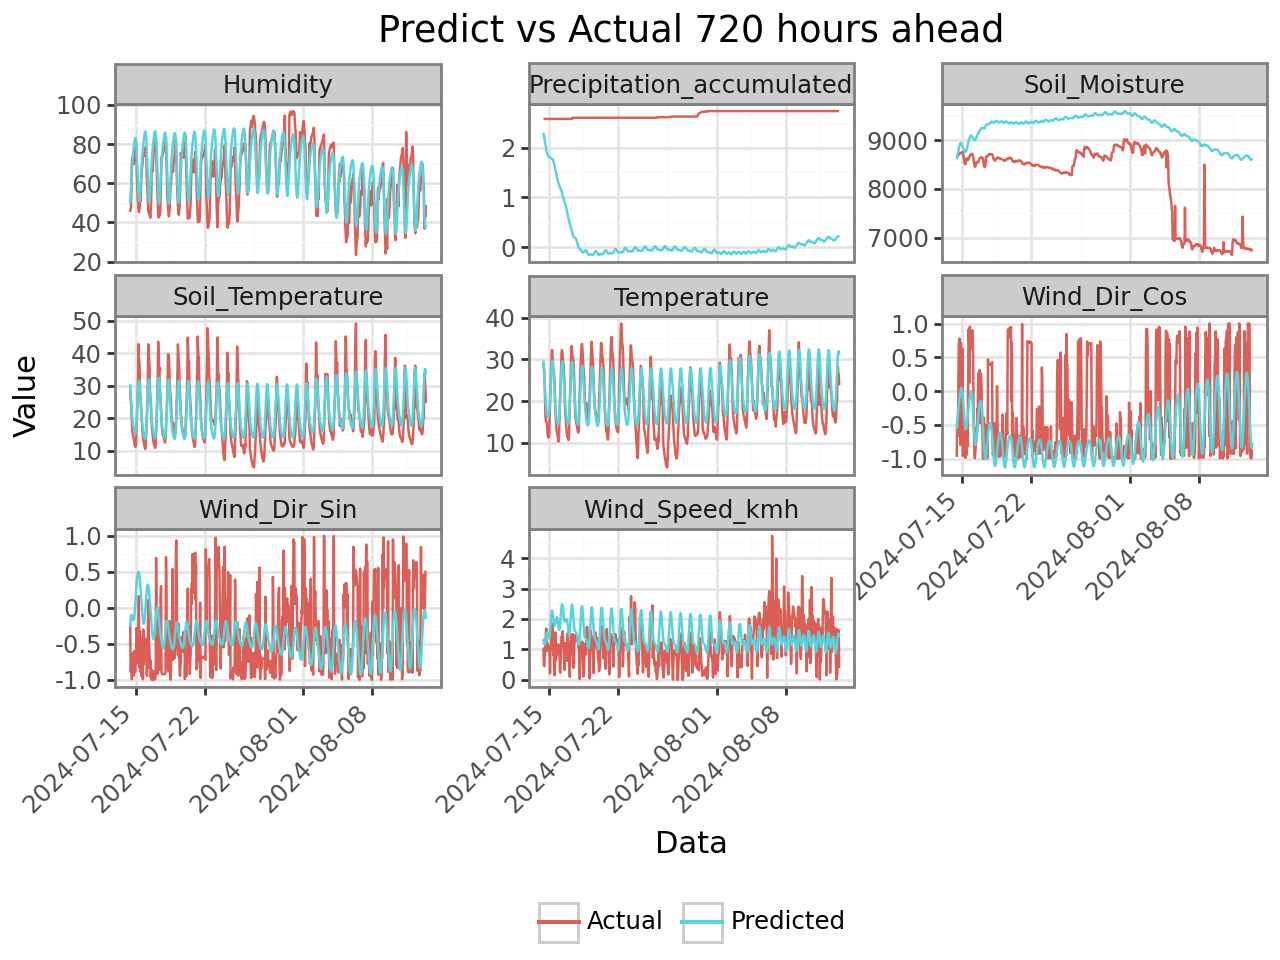

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/LSTM/predict_720.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(18.300277357799004), 'RMSE': np.float64(4.277882345015931), 'MAE': np.float64(3.627003707434324), 'R2': np.float64(0.6371729208323358), 'SMAPE': np.float64(19.999238678247973)}, 'Precipitation_accumulated': {'MSE': np.float64(6.758337916164953), 'RMSE': np.float64(2.599680348843864), 'MAE': np.float64(2.5563361049823294), 'R2': np.float64(-1527.9231425975313), 'SMAPE': np.float64(183.94217361462117)}, 'Humidity': {'MSE': np.float64(93.04398260186696), 'RMSE': np.float64(9.645930883116826), 'MAE': np.float64(8.044970017068733), 'R2': np.float64(0.6526486127763835), 'SMAPE': np.float64(13.276523996861563)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.5663708381213886), 'RMSE': np.float64(0.7525761344351737), 'MAE': np.float64(0.6105828278769633), 'R2': np.float64(-0.27090848636282305), 'SMAPE': np.float64(52.6549645609759)}, 'Soil_Moisture': {'MSE': np.float64(1552297.0246744566), 'RMSE': np.float64(1245.9121255828825), 'MAE': np.float64(1087.5436746579355),

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

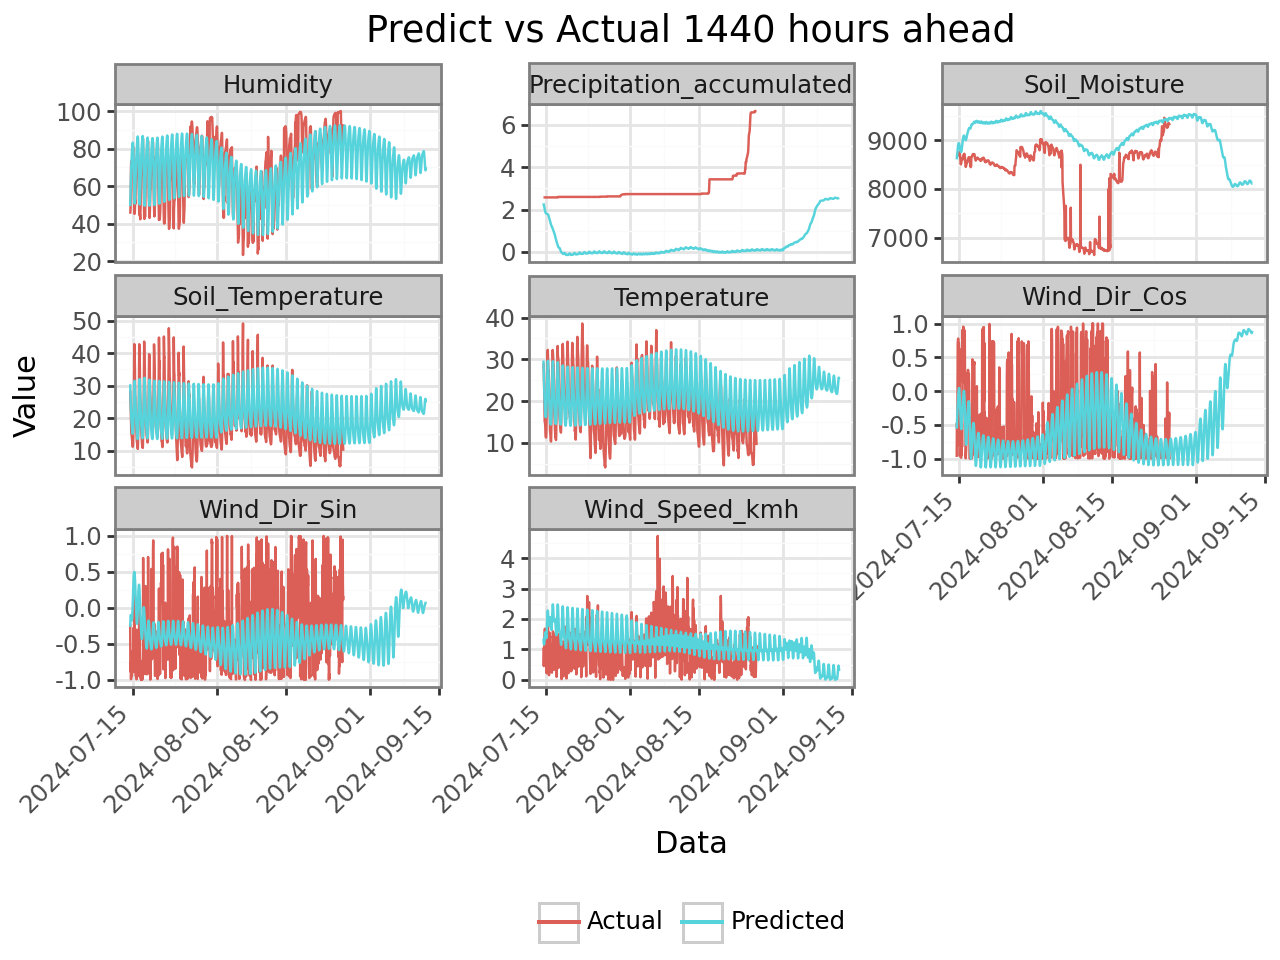

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/LSTM/predict_1440.png


{'Temperature': {'MSE': np.float64(22.433322932179), 'RMSE': np.float64(4.736382895436031), 'MAE': np.float64(4.103922716782593), 'R2': np.float64(0.554008839464152), 'SMAPE': np.float64(24.34547343435913)}, 'Precipitation_accumulated': {'MSE': np.float64(9.16747943035506), 'RMSE': np.float64(3.027784574627967), 'MAE': np.float64(2.8930979914983874), 'R2': np.float64(-13.845512413416506), 'SMAPE': np.float64(186.77502031934063)}, 'Humidity': {'MSE': np.float64(115.88048190895992), 'RMSE': np.float64(10.764779696257603), 'MAE': np.float64(8.745320322232434), 'R2': np.float64(0.6270558612963968), 'SMAPE': np.float64(13.434285572449966)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.4820314357227486), 'RMSE': np.float64(0.6942848376010732), 'MAE': np.float64(0.5589068529149416), 'R2': np.float64(-0.15792175425805377), 'SMAPE': np.float64(53.309312558964805)}, 'Soil_Moisture': {'MSE': np.float64(1236187.074111288), 'RMSE': np.float64(1111.8395001578635), 'MAE': np.float64(933.3760950814285), 'R2

In [17]:
m = "LSTM"
for i in [3,6,12,24,48,72,168,336,720,1440]:
    pred = model.predict(
        series=best_train_scaled,
        n=i,
        verbose=True
    )

    metrics={}

    pred_t = best_scaler.inverse_transform(pred)
    pred_df = pred_t.to_dataframe()
    pred_df = pred_df.reset_index()
    pred_df = pred_df.rename(columns={"time": "Timestamp"})
    plot_columns = ['Timestamp'] + target_columns
    pred_melted = pred_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    pred_melted['type'] = 'Predicted'

    # Get validation data for comparison
    val_t = best_scaler.inverse_transform(best_val_scaled[:i])
    val_df = val_t.to_dataframe()
    val_df = val_df.reset_index()
    val_df = val_df.rename(columns={"time": "Timestamp"})
    val_melted = val_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    val_melted['type'] = 'Actual'

    # Combine predicted and validation data
    combined_df = pd.concat([pred_melted, val_melted])

    plot = (
        ggplot(combined_df, aes(x='Timestamp', y='value', color='type'))
        + geom_line()
        + facet_wrap('~ target_column', scales='free_y')
        + labs(
            title=f'Predict vs Actual {i} hours ahead',
            x='Data',
            y='Value',
            color='Data type'
        )
        + theme_bw()
        + theme(
            axis_text_x=element_text(rotation=45, hjust=1),
            legend_position='bottom',
            legend_title=element_blank(),

        )
    )
    plot.show()
    plot.save(f'results/{m}/predict_{i}.png', width=12, height=10, dpi=300)


    s = best_scaler.inverse_transform(best_val_scaled[:i])
    for target in target_columns:
        metrics[target] = {
            'MSE': mse(s[target], pred_t[target]),
            'RMSE': rmse(s[target], pred_t[target]),
            'MAE': mae(s[target], pred_t[target]),
            'R2': r2_score(s[target], pred_t[target]),
            'SMAPE': smape(s[target], pred_t[target]),
        }
    print(metrics)
    with open(f'results/{m}/metrics{i}.json', 'w') as f:
        json.dump(metrics, f, indent=4)


In [18]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)